In [73]:
import ROOT
import uproot
import matplotlib.pyplot as plt
import scipy as scp
from scipy.integrate import trapezoid
import numpy as np
import awkward as ak

In [74]:
#Open root file with both shapes and measurements

FILE_PATH = "../Dati/Run_cfd_0.5_ledge_Data_5_9_2024_Ascii.root" #Relative file path
file = uproot.open(FILE_PATH)
file["tree"].show() #Display contents

FILE_PATH='../Dati/Run_cfd_0.5_ledge_meas_only_Measurements_Only_5_9_2024_0000.root'
file2=uproot.open(FILE_PATH)
print("\n")
file2["tree"].show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
ev                   | int32_t                  | AsDtype('>i4')
nch                  | int32_t                  | AsDtype('>i4')
ch                   | int32_t[]                | AsJagged(AsDtype('>i4'))
base                 | float[]                  | AsJagged(AsDtype('>f4'))
amp                  | float[]                  | AsJagged(AsDtype('>f4'))
charge               | float[]                  | AsJagged(AsDtype('>f4'))
letime               | float[]                  | AsJagged(AsDtype('>f4'))
tetime               | float[]                  | AsJagged(AsDtype('>f4'))
ratecount            | float[]                  | AsJagged(AsDtype('>f4'))
pshape               | float[][1024]            | AsJagged(AsDtype("('>f4', (...


name                 | typename                 | interpretation                
-------------------

In [75]:
print(type(file["tree"]["base"].array()))
bl=file["tree"]["base"].array()
print(ak.num(bl))
bl = bl[:-1]
print(np.unique(ak.num(bl)))
#l'ultimo array aveva una forma diversa, quindi l'ho tagliato altrimenti faceva casini

<class 'awkward.highlevel.Array'>
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ..., 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[2]


In [76]:
nch=file["tree"]["ch"].array()[:-1]
print(nch)

[[5, 13], [5, 13], [5, 13], [5, 13], ..., [5, ...], [5, 13], [5, 13], [5, 13]]


In [77]:
#Load data to numpy arrays

baselines = np.array(file2["tree"]["base"].array()[:-1]) #il [:-1] toglie l'ultimo evento che si è splittato male
charges = np.array(file2["tree"]["charge"].array()[:-1])
amp = np.array(file2["tree"]["amp"].array()[:-1])
lead_edge = np.array(file2["tree"]["letime"].array()[:-1])
t_edge = np.array(file2["tree"]["tetime"].array()[:-1])
channel= np.array(file2["tree"]["ch"].array()[:-1])
waveform = np.array(file["tree"]["pshape"].array()[:-1])

In [78]:
N_ev=len(charges[:, 0])
print(N_ev)

4114


In [80]:
print(len(waveform[0][0]))

1024


-1.0
[]
0


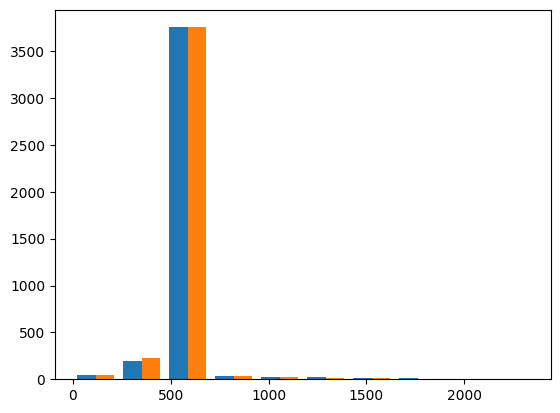

In [82]:
plt.hist(t_edge)
print(np.min(t_edge))
print(np.where(t_edge[:,1]==-1)[0])
print(len(np.where(t_edge[:,1]==-1)[0]))


(array([[4.800e+01, 2.500e+02, 3.803e+03, 1.200e+01, 0.000e+00, 1.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
        [4.400e+01, 2.190e+02, 3.805e+03, 4.000e+01, 2.000e+00, 1.000e+00,
         1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]]),
 array([-1.00000000e+00,  2.17577805e+02,  4.36155609e+02,  6.54733398e+02,
         8.73311218e+02,  1.09188904e+03,  1.31046680e+03,  1.52904468e+03,
         1.74762244e+03,  1.96620032e+03,  2.18477808e+03]),
 <a list of 2 BarContainer objects>)

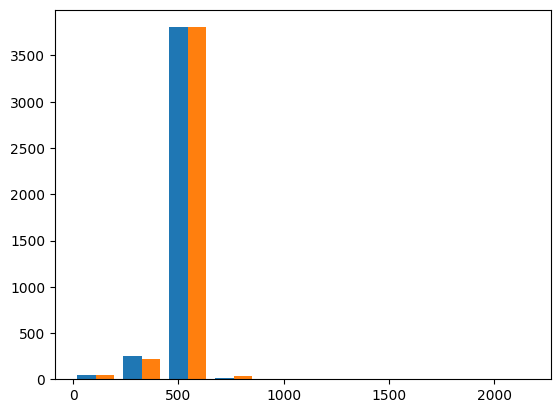

In [83]:
plt.hist(lead_edge)

(4114, 2, 1024)
channel: 0 baseline: 0.00044 charge -956.717 lead_edge 495.692 trailing_edge 555.27
495.692 555.27
channel: 1 baseline: 0.000512 charge -568.988 lead_edge 539.468 trailing_edge 552.774
539.468 552.774


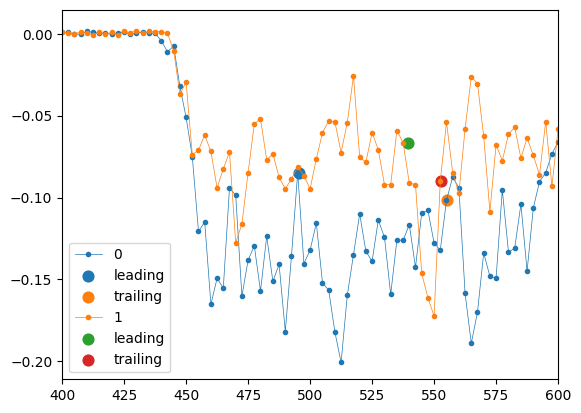

In [91]:
print(waveform.shape)
event= 2000
#tra 5 e 13
list = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
list=[0,1]
sampling=2.5
for channel in list:
    time=np.arange(1024)
    plt.plot(time*sampling, waveform[event][channel], '.-', label='{}'.format(channel), linewidth=0.5)
    print("channel:", channel, "baseline:",  baselines[event][channel],"charge", charges[event][channel], "lead_edge", lead_edge[event][channel], "trailing_edge", t_edge[event][channel] )
    t1=lead_edge[event][channel]
    t2=t_edge[event][channel]
    print(t1,t2)
    plt.scatter( t1, waveform[event][channel][int(t1/sampling)],s=60 ,  label='leading'  )
    plt.scatter( t2, waveform[event][channel][int(t2/sampling)],s=60,  label='trailing'  )
    plt.legend()
    plt.xlim(400,600)
    #plt.ylim(-0.01, 0.1)

plt.legend()

In [49]:
canale=[0,1,2,3,4,5,8,9,12,13,14,15]
#l'ultimo è il 15
carica_gamma=[-492.991122,-869.542194, -755.683667, -1125.16284, -1223.87088, -1268.36734, 0, 0, -879.024502, -440.515158,0, 0,  -706.002694,
              -734.448274, -1088.07980, -1595.94856]
sigma_gamma=[55.3238139,60.6593683, 68.7226953, 89.3657356,  82.0439831, 97.4454060, 0, 0,  131.835623, 34.3645975, 0, 0, 122.979607,
             72.0804643, 79.5176462 ,95.8597859]
n=4 #sigma che accettiamo

firstch_limits=[[carica_gamma[0]-n*sigma_gamma[0], carica_gamma[0]+n*sigma_gamma[0]], [carica_gamma[4]-n*sigma_gamma[4], carica_gamma[4]+n*sigma_gamma[4]], [carica_gamma[5]-n*sigma_gamma[5], carica_gamma[5]+n*sigma_gamma[5]] ,
 [carica_gamma[9]-n*sigma_gamma[9], carica_gamma[9]+n*sigma_gamma[9]] , [carica_gamma[12]-n*sigma_gamma[12], carica_gamma[12]+n*sigma_gamma[12]] , 
 [carica_gamma[14]-n*sigma_gamma[14], carica_gamma[14]+n*sigma_gamma[14]]]

secondch_limits=[[carica_gamma[8]-n*sigma_gamma[8], carica_gamma[8]+n*sigma_gamma[8]], [carica_gamma[1]-n*sigma_gamma[1], carica_gamma[1]+n*sigma_gamma[1]], [carica_gamma[13]-n*sigma_gamma[13], carica_gamma[13]+n*sigma_gamma[13]] ,
 [carica_gamma[2]-n*sigma_gamma[2], carica_gamma[2]+n*sigma_gamma[2]] , [carica_gamma[3]-n*sigma_gamma[3], carica_gamma[3]+n*sigma_gamma[3]] , 
 [carica_gamma[15]-n*sigma_gamma[15], carica_gamma[15]+n*sigma_gamma[15]]]

In [55]:
#liste con le coppie

#coppia=np.array([ [0,8], [4,1], [5,13], [9,2], [12,3], [14,15] ])
coppia = np.array([[5,13]])

firstch = coppia[:,0]
secondch = coppia[:,1]


map = np.repeat(-1,16)

for i in range(16):
    if np.where(coppia.flatten()==i)[0].size>0:
        map[i]=np.where(coppia.flatten()==i)[0]
print(map)

firstch_limits=    [  [carica_gamma[coppia[i][0]]-n*sigma_gamma[coppia[i][0]], carica_gamma[coppia[i][0]]+n*sigma_gamma[coppia[i][0]] ] for i in range(len(coppia))]
secondch_limits= [  [carica_gamma[coppia[i][1]]-n*sigma_gamma[coppia[i][0]], carica_gamma[coppia[i][1]]+n*sigma_gamma[coppia[i][1]] ] for i in range(len(coppia))   ]



paired_amp_1 = []
paired_charge_1 = []
paired_letime_1 = []
paired_wf_1 = []

paired_amp_2 = []
paired_charge_2 = []
paired_letime_2 = []
paired_wf_2 = []

whichpair=[]

for event in range(N_ev):
    for channel1,channel2, limF, limS in zip(map[firstch],map[secondch],firstch_limits,secondch_limits):
        #controllo se c'è un evento nel primo della coppia
        if(charges[event][channel1] >= limF[0] and charges[event][channel1] <= limF[1]):
            #se sì, vedo se ce n'è uno anche nel secondo della coppia
            if (charges[event][channel2] >= limS[0] and charges[event][channel2] <= limS[1]):
                #salvo i parametri del primo canale della coppia
                whichpair.append(channel1)

                paired_amp_1.append(amp[event][channel1])
                paired_charge_1.append(charges[event][channel1])
                paired_letime_1.append(lead_edge[event][channel1])
                paired_wf_1.append(waveform[event][channel1])

                paired_amp_2.append(amp[event][channel2])
                paired_charge_2.append(charges[event][channel2])
                paired_letime_2.append(lead_edge[event][channel2])
                paired_wf_2.append(waveform[event][channel2])
                



        


[-1 -1 -1 -1 -1  0 -1 -1 -1 -1 -1 -1 -1  1 -1 -1]


2683
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

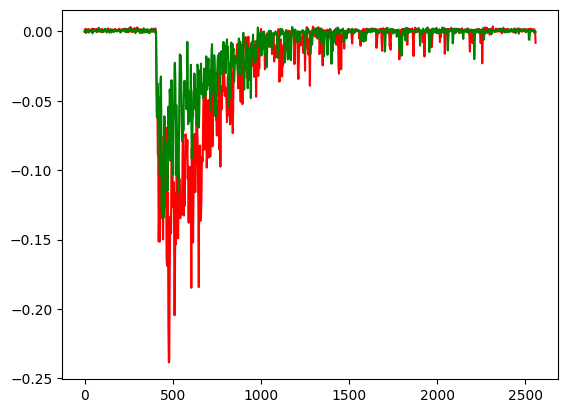

In [56]:
print(len(paired_amp_1))
print(whichpair)

plt.plot(time*sampling, paired_wf_1[1], color = 'red')
plt.plot(time*sampling, paired_wf_2[1], color = 'green')

2271
[  0.    0.    5.  ...   2.5   2.5 255. ]


(array([  2.,   0.,   0.,   0.,   0.,   2.,   0.,   9.,   0.,   0.,  26.,
          0.,  59.,   0.,   0., 187.,   0., 359.,   0.,   0., 598.,   0.,
        664.,   0.,   0., 463.,   0., 171.,   0.,   0.,  52.,   0.,  11.,
          0.,   0.,   5.,   0.,   2.,   0.,   0.]),
 array([-20., -19., -18., -17., -16., -15., -14., -13., -12., -11., -10.,
         -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,
         13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.]),
 <BarContainer object of 40 artists>)

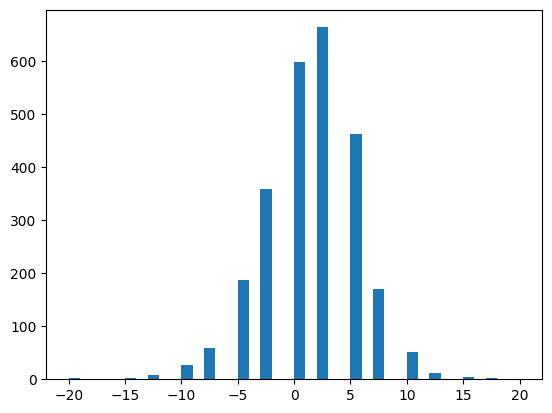

In [63]:
#trigger di ogni canale
firstch_trigger=[-0.028, -0.035, -0.028, -0.03, -0.03, -0.035]
secondch_trigger = [-0.03, -0.027, -0.022, -0.03, -0.028, -0.04]

triggering_index_1=[np.where(paired_wf_1[ind] <= firstch_trigger[pair])[0][0] for ind, pair in enumerate(whichpair)]
triggering_index_2=[np.where(paired_wf_2[ind] <= secondch_trigger[pair])[0][0] for ind, pair in enumerate(whichpair)]

#convert to numpy array
triggering_index_1= np.array(triggering_index_1)
triggering_index_2= np.array(triggering_index_2)
rough_timeres=(triggering_index_1 - triggering_index_2)*2.5
print(np.argmax(rough_timeres))
print(rough_timeres)
plt.hist(rough_timeres, bins=40, range=(-20,20))